# Анализ битых DOM-элементов с использованием машинного обучения

Данный ноутбук представляет собой исследование методов обнаружения битых DOM-элементов на веб-страницах с использованием методов машинного обучения.

## Задача
Разработать систему, которая исследует DOM-структуру веб-страницы и выявляет битые элементы.

### Критерии отнесения к "битым" элементам:
1. Пустые или отсутствующие ключевые атрибуты (src, href, type, alt)
2. Скрытые элементы, участвующие в логике интерфейса
3. Конфликт CSS-стилей, делающий элемент невидимым
4. Повреждённые вложенные структуры (например, незакрытые теги, вложенные ссылки и т.д.)

## Импорт необходимых библиотек

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
import joblib
import os
import sys

# Добавляем директорию src в путь для импорта
# Определяем абсолютный путь к корневой директории проекта
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
# Добавляем корневую директорию проекта в sys.path
sys.path.append(project_dir)

# Теперь импортируем из локального файла
from src.data_generator import generate_synthetic_data, save_data

# Устанавливаем стиль для графиков
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Генерация данных

Генерируем синтетические данные для обучения модели, если они еще не созданы

In [122]:
# Проверяем наличие синтетических данных или генерируем их
if not os.path.exists('../data/dom_elements.csv'):
    print("Синтетические данные не найдены. Запуск генерации синтетических данных...")
    df_synthetic = generate_synthetic_data(n_samples=5000)
    save_data(df_synthetic)
else:
    print("Синтетические данные уже существуют. Загружаем из файла...")
    df_synthetic = pd.read_csv('../data/dom_elements.csv')

print(f"Загружено {len(df_synthetic)} синтетических записей")
print(f"Из них битых элементов: {df_synthetic['is_broken'].sum()} ({df_synthetic['is_broken'].mean()*100:.2f}%)")

# Проверяем наличие собранных данных и загружаем их
if os.path.exists('../data/collected_dom_elements.csv'):
    print("\nНайдены собранные с реальных сайтов данные. Загружаем...")
    df_collected = pd.read_csv('../data/collected_dom_elements.csv')
    print(f"Загружено {len(df_collected)} собранных записей")
    print(f"Из них битых элементов: {df_collected['is_broken'].sum()} ({df_collected['is_broken'].mean()*100:.2f}%)")

    # Объединяем синтетические и собранные данные
    print("\nОбъединяем синтетические и собранные данные для обучения...")

    # Проверяем и приводим столбцы к одинаковому формату
    # Получаем список общих столбцов для обоих датасетов
    common_columns = list(set(df_synthetic.columns).intersection(set(df_collected.columns)))

    # Используем только общие столбцы для объединения датасетов
    df = pd.concat([df_synthetic[common_columns], df_collected[common_columns]], ignore_index=True)

    print(f"Общее количество записей после объединения: {len(df)}")
    print(f"Общее количество битых элементов: {df['is_broken'].sum()} ({df['is_broken'].mean()*100:.2f}%)")
else:
    print("\nСобранные данные не найдены. Используем только синтетические данные.")
    df = df_synthetic

# Показываем первые несколько записей объединенного датасета
df.head()

Синтетические данные уже существуют. Загружаем из файла...
Загружено 5000 синтетических записей
Из них битых элементов: 757 (15.14%)

Найдены собранные с реальных сайтов данные. Загружаем...
Загружено 3436 собранных записей
Из них битых элементов: 84 (2.44%)

Объединяем синтетические и собранные данные для обучения...
Общее количество записей после объединения: 8436
Общее количество битых элементов: 841 (9.97%)


,is_interactive,attr_count,is_broken,missing_required_attr,has_empty_attr,tag,depth,nested_structure_issue,has_display_none,has_text,visibility,css_conflict
0,0,7,0,0,1,span,7,0,0,0,1,0
1,1,0,0,0,0,button,9,0,0,0,1,0
2,0,0,1,1,0,h1,8,1,0,1,1,1
3,0,0,0,0,0,div,8,0,0,0,1,0
4,1,1,1,1,1,input,4,0,0,1,1,0


## Разведочный анализ данных

Исследуем структуру и распределение данных для лучшего понимания проблемы

In [123]:
# Общая информация о датасете
print("Информация о датасете:")
# Выводим более полную информацию с отображением всех строк и более понятным форматом
pd.set_option('display.max_info_columns', 500)  # Устанавливаем большое число для отображения всех столбцов
df.info(verbose=True, show_counts=True, memory_usage='deep')
# Восстанавливаем стандартные настройки отображения
pd.reset_option('display.max_info_columns')

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8436 entries, 0 to 8435
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   is_interactive          8436 non-null   int64 
 1   attr_count              8436 non-null   int64 
 2   is_broken               8436 non-null   int64 
 3   missing_required_attr   8436 non-null   int64 
 4   has_empty_attr          8436 non-null   int64 
 5   tag                     8436 non-null   object
 6   depth                   8436 non-null   int64 
 7   nested_structure_issue  8436 non-null   int64 
 8   has_display_none        8436 non-null   int64 
 9   has_text                8436 non-null   int64 
 10  visibility              8436 non-null   int64 
 11  css_conflict            8436 non-null   int64 
dtypes: int64(11), object(1)
memory usage: 1.2 MB


In [124]:
# Статистика по числовым признакам
df.describe()

,is_interactive,attr_count,is_broken,missing_required_attr,has_empty_attr,depth,nested_structure_issue,has_display_none,has_text,visibility,css_conflict
count,8436.000000,8436.000000,8436.000000,8436.000000,8436.000000,8436.000000,8436.000000,8436.000000,8436.000000,8436.000000,8436.000000
mean,0.381935,3.418919,0.099692,0.191916,0.206259,9.475936,0.091868,0.062707,0.580014,0.939071,0.090920
std,0.485889,2.731700,0.299606,0.393830,0.404643,6.445836,0.288857,0.242450,0.493585,0.239215,0.287512
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,2.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,6.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,10.000000,1.000000,1.000000,1.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000


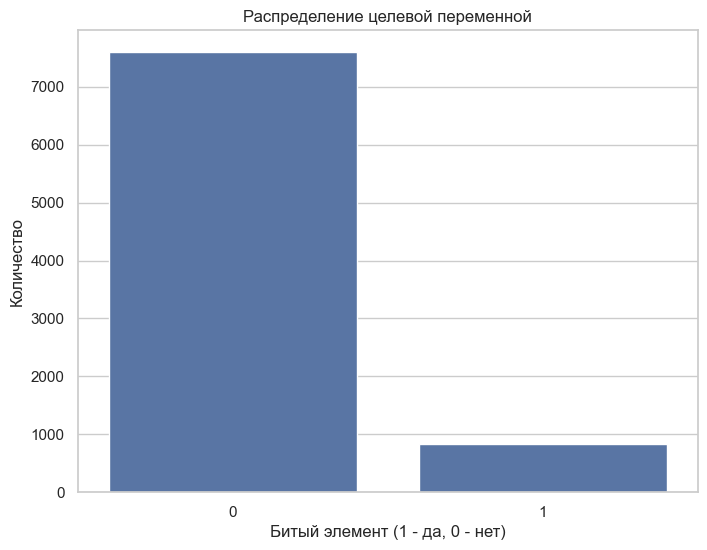

In [125]:
# Распределение целевой переменной
plt.figure(figsize=(8, 6))
sns.countplot(x='is_broken', data=df)
plt.title('Распределение целевой переменной')
plt.xlabel('Битый элемент (1 - да, 0 - нет)')
plt.ylabel('Количество')
plt.show()

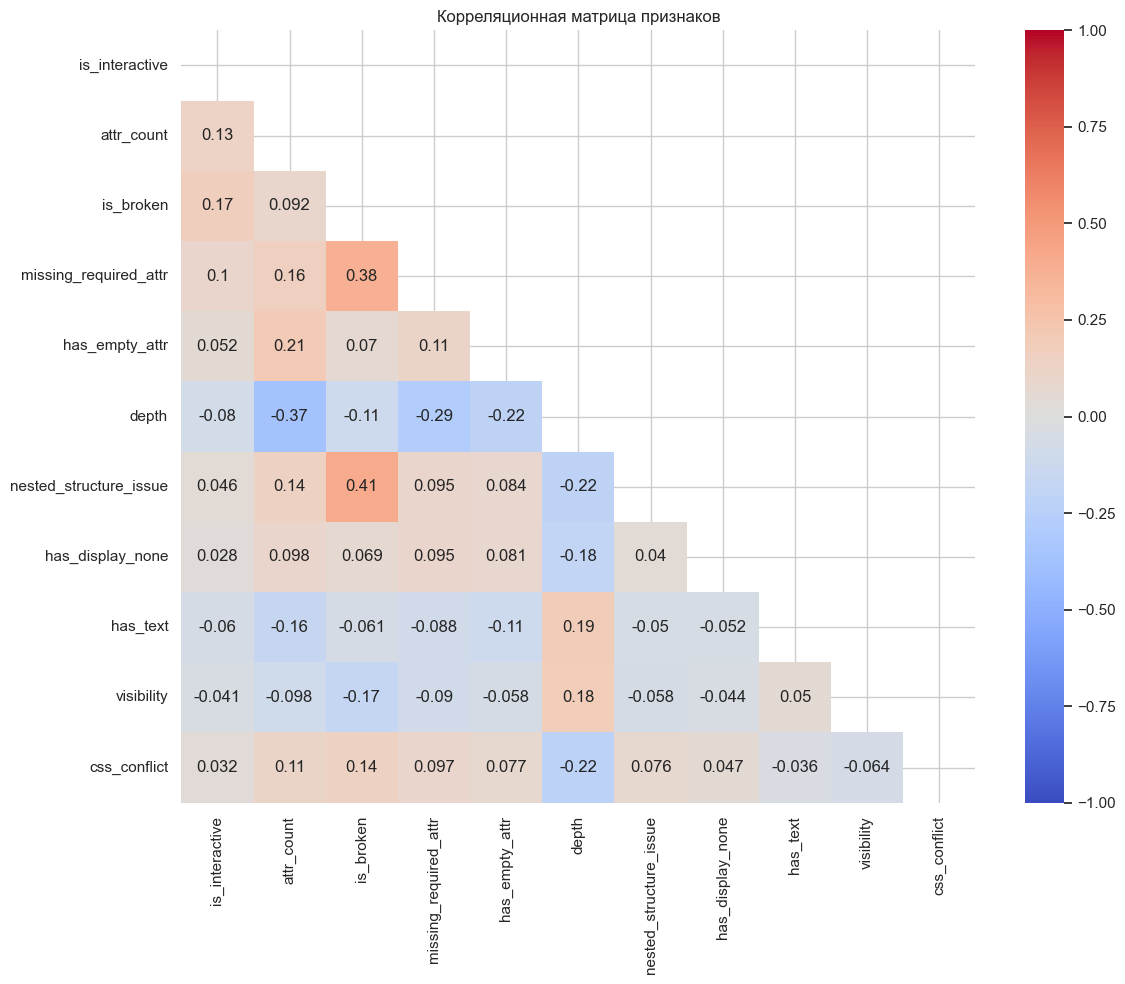

In [126]:
# Корреляционная матрица
plt.figure(figsize=(12, 10))
corr = df.select_dtypes(include=['number']).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляционная матрица признаков')
plt.tight_layout()
plt.show()

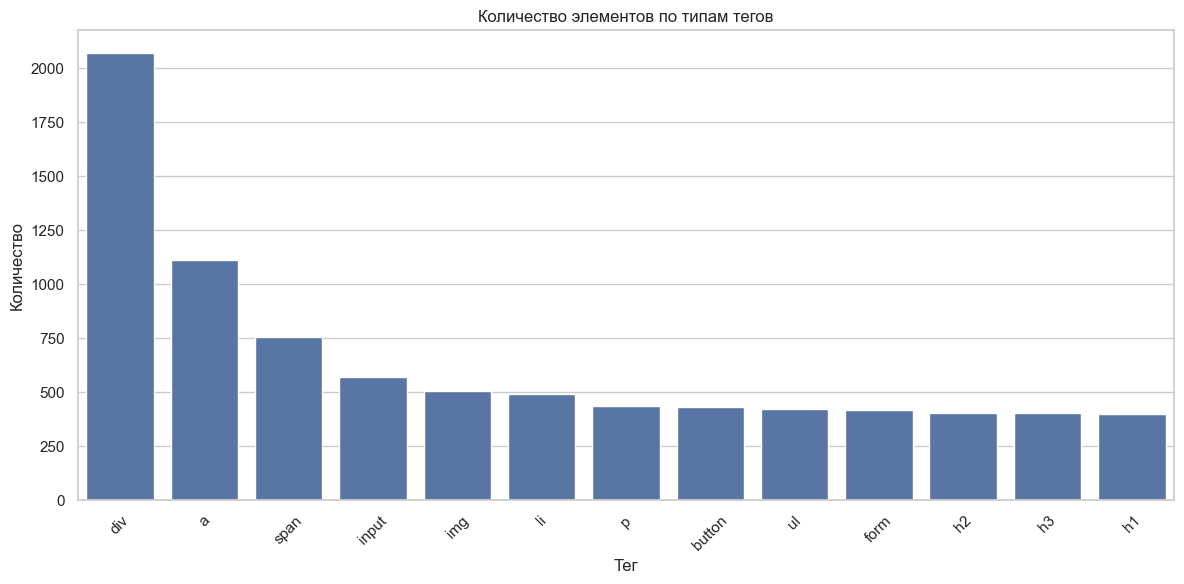

In [127]:
# Распределение по типам тегов
plt.figure(figsize=(12, 6))
tag_counts = df['tag'].value_counts()
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.title('Количество элементов по типам тегов')
plt.xlabel('Тег')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

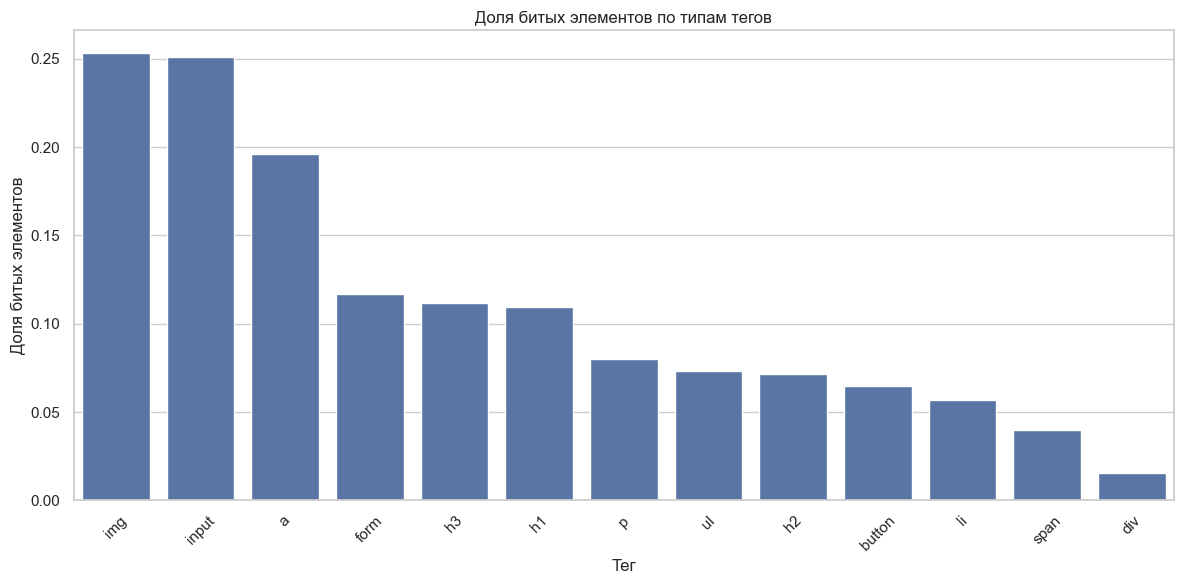

In [128]:
# Доля битых элементов по типам тегов
plt.figure(figsize=(12, 6))
tag_broken = df.groupby('tag')['is_broken'].mean().sort_values(ascending=False)
sns.barplot(x=tag_broken.index, y=tag_broken.values)
plt.title('Доля битых элементов по типам тегов')
plt.xlabel('Тег')
plt.ylabel('Доля битых элементов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Подготовка данных для обучения

Подготавливаем данные для обучения модели: кодируем категориальные признаки и разделяем на обучающую и тестовую выборки

In [129]:
# Преобразуем категориальные признаки
df_encoded = pd.get_dummies(df, columns=['tag'], drop_first=True)

# Разделяем признаки и целевую переменную
X = df_encoded.drop('is_broken', axis=1)
y = df_encoded['is_broken']

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (5905, 22)
Размер тестовой выборки: (2531, 22)


## Сравнение различных алгоритмов машинного обучения

Сравниваем различные алгоритмы классификации для выбора наиболее подходящего

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Определяем модели для сравнения
models = {
    'Логистическая регрессия': LogisticRegression(max_iter=1000, random_state=42),
    'K-ближайших соседей': KNeighborsClassifier(),
    'Дерево решений': DecisionTreeClassifier(random_state=42),
    'Случайный лес': RandomForestClassifier(n_estimators=100, random_state=42),
    'Градиентный бустинг': GradientBoostingClassifier(random_state=42)
}

# Сравниваем модели по метрикам
results = {}
for name, model in models.items():
    print(f"Оценка модели: {name}...")
    # Используем кросс-валидацию для более надежной оценки
    cv_accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_f1 = cross_val_score(model, X, y, cv=5, scoring='f1')
    cv_precision = cross_val_score(model, X, y, cv=5, scoring='precision')
    cv_recall = cross_val_score(model, X, y, cv=5, scoring='recall')

    results[name] = {
        'accuracy': cv_accuracy.mean(),
        'f1': cv_f1.mean(),
        'precision': cv_precision.mean(),
        'recall': cv_recall.mean()
    }

# Преобразуем результаты в DataFrame для удобного отображения
results_df = pd.DataFrame(results).T
results_df

Оценка модели: Логистическая регрессия...
Оценка модели: K-ближайших соседей...
Оценка модели: Дерево решений...
Оценка модели: Случайный лес...
Оценка модели: Градиентный бустинг...


,accuracy,f1,precision,recall
Логистическая регрессия,0.925321,0.566006,0.741574,0.490976
K-ближайших соседей,0.932669,0.523686,0.872057,0.391103
Дерево решений,0.988026,0.922778,0.989443,0.890483
Случайный лес,0.986367,0.911719,0.997568,0.865518
Градиентный бустинг,0.981743,0.883356,0.997531,0.819062


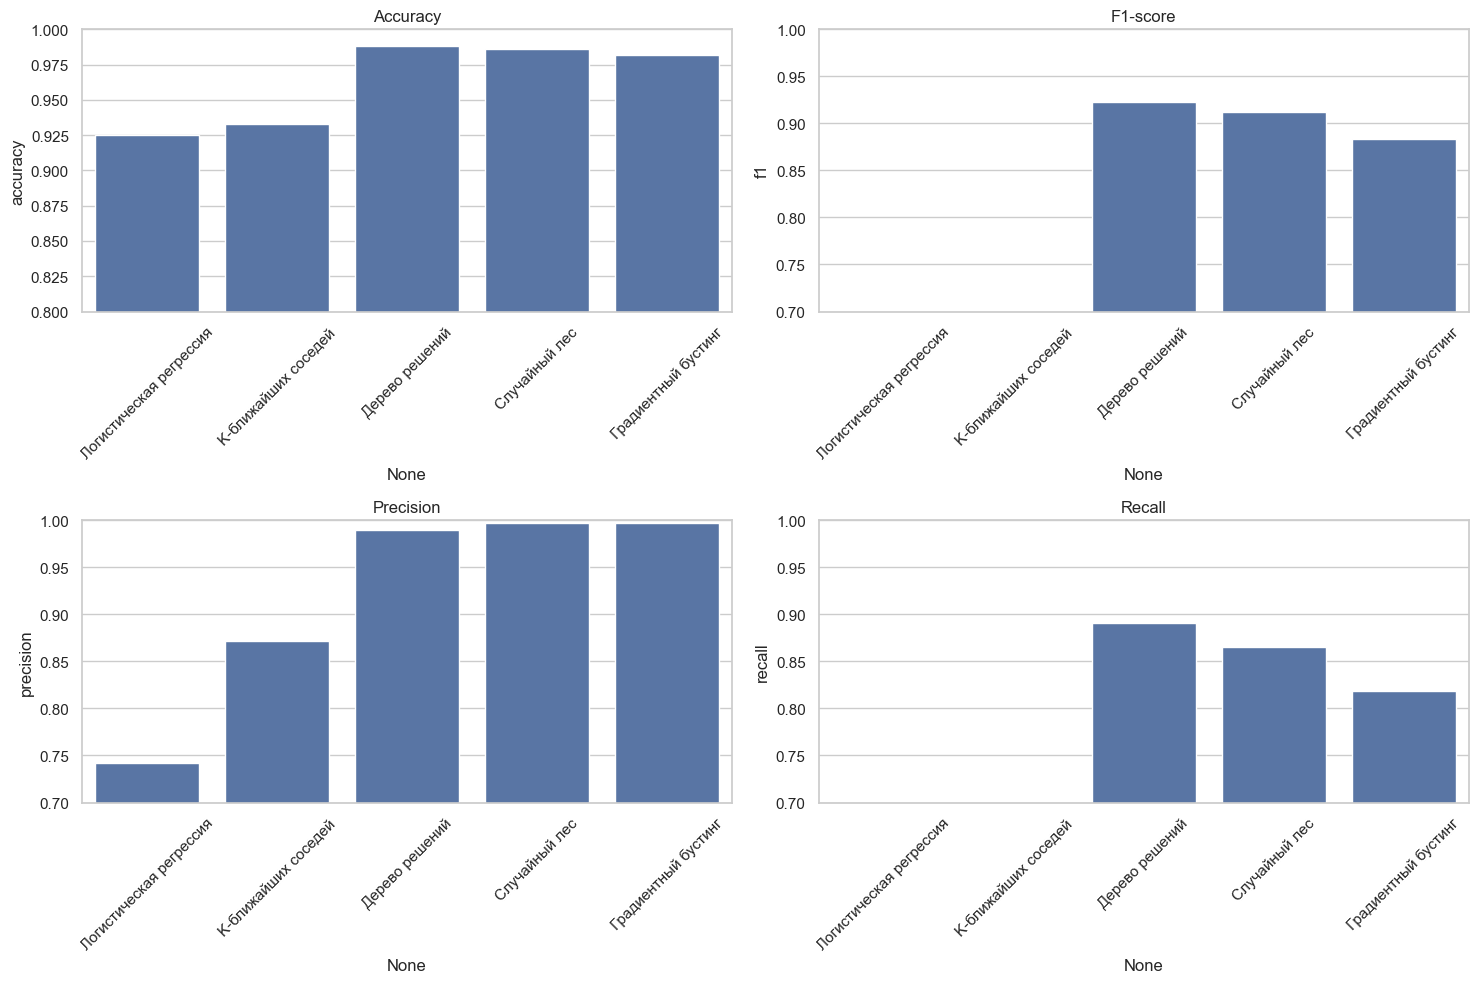

In [131]:
# Визуализируем результаты сравнения моделей
plt.figure(figsize=(15, 10))

# Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y=results_df['accuracy'])
plt.title('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

# F1-score
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y=results_df['f1'])
plt.title('F1-score')
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)

# Precision
plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y=results_df['precision'])
plt.title('Precision')
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)

# Recall
plt.subplot(2, 2, 4)
sns.barplot(x=results_df.index, y=results_df['recall'])
plt.title('Recall')
plt.xticks(rotation=45)
plt.ylim(0.7, 1.0)

plt.tight_layout()
plt.show()

## Обучение модели Random Forest

Согласно требованиям, используем Random Forest для основной модели. Проведем оптимизацию гиперпараметров с помощью GridSearchCV.

In [132]:
# Определяем параметры для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создаем базовую модель
rf = RandomForestClassifier(random_state=42)

# Поиск оптимальных параметров с помощью перекрестной проверки
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='f1'
)

grid_search.fit(X_train, y_train)

# Выводим лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший F1-score: {grid_search.best_score_:.4f}")

# Получаем лучшую модель
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучший F1-score: 0.9818


## Оценка качества модели

Оцениваем качество обученной модели на тестовой выборке

In [133]:
# Прогнозы на обучающей выборке
y_train_pred = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Прогнозы на тестовой выборке
y_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy на обучающей выборке: {train_accuracy:.4f}")
print(f"Accuracy на тестовой выборке: {test_accuracy:.4f}")

print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))

Accuracy на обучающей выборке: 1.0000
Accuracy на тестовой выборке: 0.9960

Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2279
           1       1.00      0.96      0.98       252

    accuracy                           1.00      2531
   macro avg       1.00      0.98      0.99      2531
weighted avg       1.00      1.00      1.00      2531



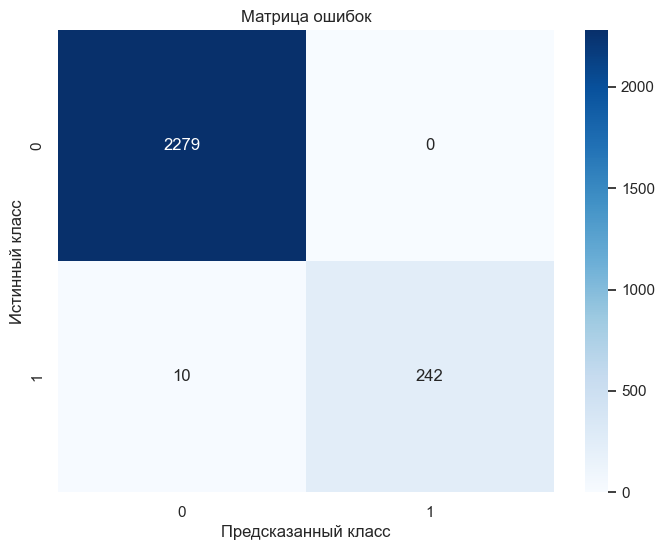

In [134]:
# Матрица ошибок
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

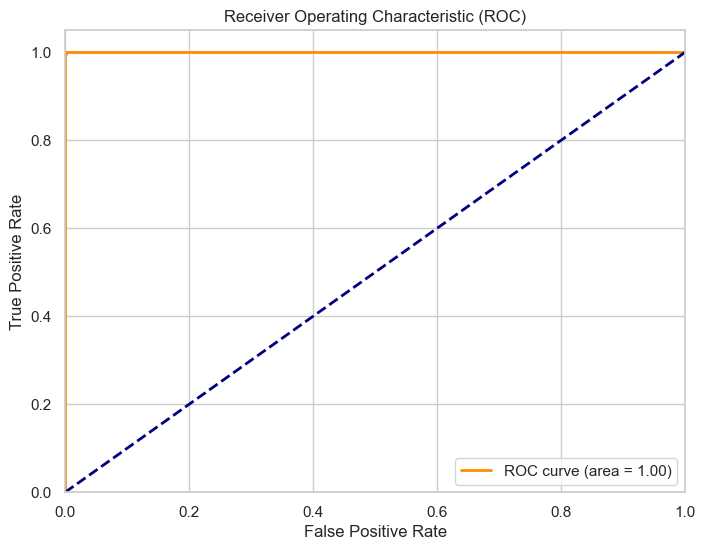

In [135]:
# ROC-кривая
y_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

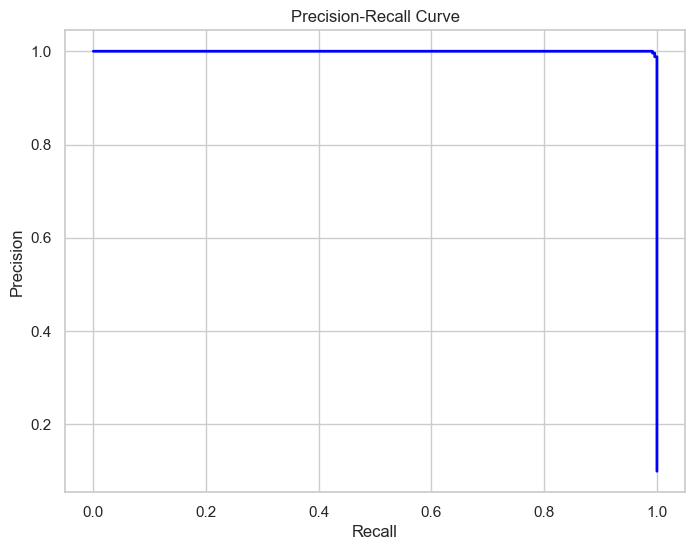

In [139]:
# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

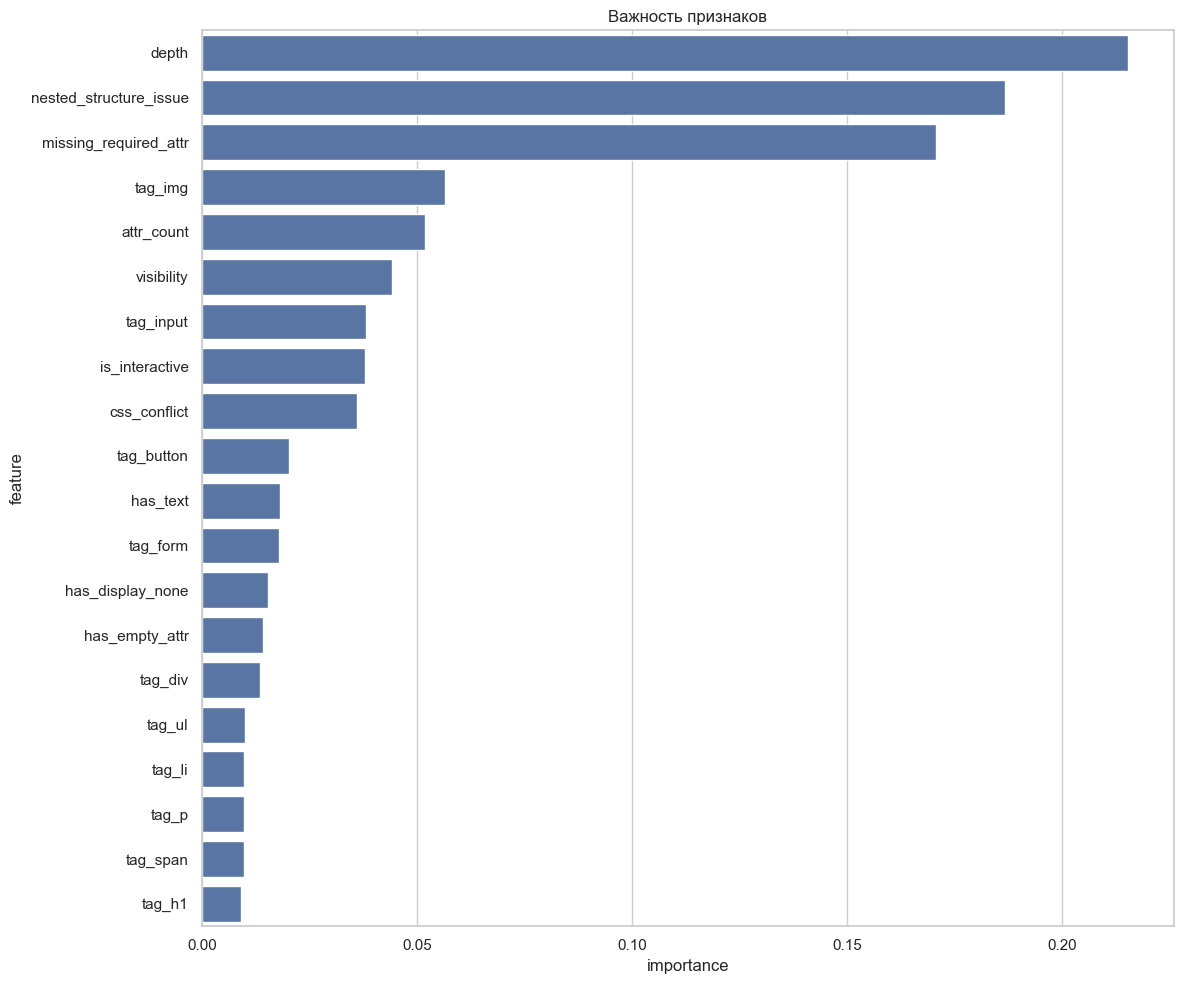

In [140]:
# Важность признаков
plt.figure(figsize=(12, 10))
feature_importance = pd.DataFrame(
    {'feature': X_train.columns, 'importance': best_rf.feature_importances_}
).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

## Сохранение модели

Сохраняем обученную модель для дальнейшего использования

In [142]:
# Сохраняем модель
os.makedirs('../models', exist_ok=True)
joblib.dump(best_rf, '../models/random_forest_model.pkl')
print("Модель сохранена в ../models/random_forest_model.pkl")

Модель сохранена в ../models/random_forest_model.pkl


## Демонстрация работы модели на новых данных

Проверяем работу модели на небольшом наборе новых данных

Модель успешно загружена из ../../models/random_forest_model.pkl
Получение DOM-элементов с сайта: https://ambientlounge.ru/modulnye-divany/collections/mod3-ottoman-trio-yellow-shine-shenill/
Найдено 3000 DOM-элементов


Анализ элементов: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 3706.72it/s]



Результаты анализа:
Всего проанализировано DOM-элементов: 3000
Выявлено битых элементов: 70 (2.33%)

Примеры выявленных битых элементов:

=== ДЕТАЛЬНАЯ ИНФОРМАЦИЯ О БИТЫХ ЭЛЕМЕНТАХ ===

1. <a class="ty-menu__item-toggle ty-menu__menu-btn visible-phone cm-responsive-menu-toggle">
   Вероятность дефекта: 1.0000
   Причины дефекта: Отсутствует обязательный атрибут 'href'
   HTML: <a class="ty-menu__item-toggle ty-menu__menu-btn visible-phone cm-responsive-menu-toggle"><i class="...
   --------------------------------------------------------------------------------

2. <a class="ty-menu__item-toggle visible-phone cm-responsive-menu-toggle">
   Вероятность дефекта: 1.0000
   Причины дефекта: Отсутствует обязательный атрибут 'href'
   HTML: <a class="ty-menu__item-toggle visible-phone cm-responsive-menu-toggle">
<i class="ut2-icon-outline-...
   --------------------------------------------------------------------------------

3. <a class="ty-menu__item-toggle ty-menu__menu-btn visible-phone

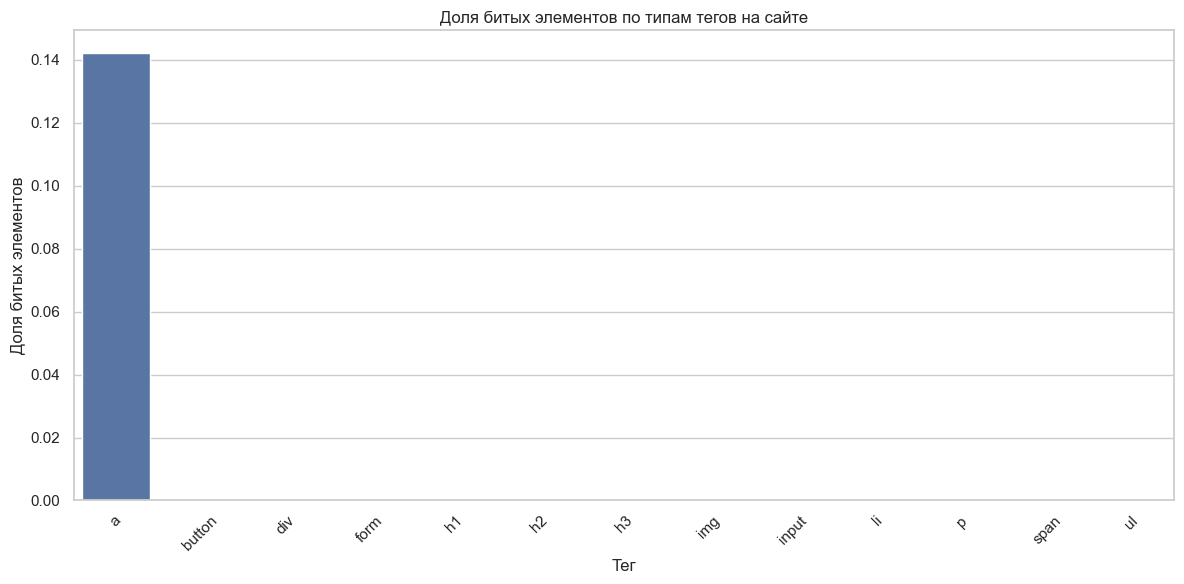

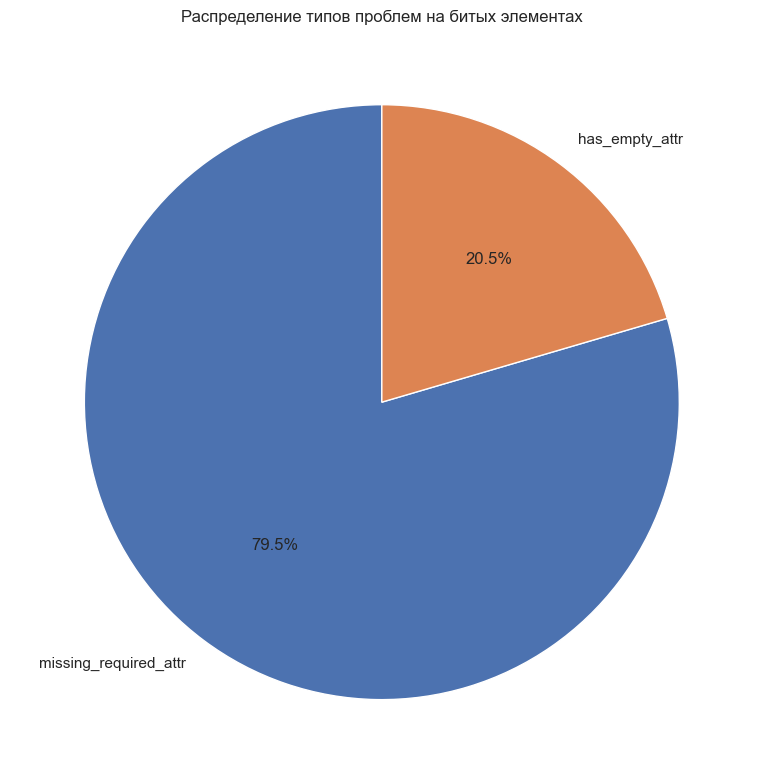

In [114]:
# Импортируем необходимые библиотеки
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Проверяем, существует ли сохраненная модель, и загружаем её
try:
    model_path = '../../models/random_forest_model.pkl'
    if os.path.exists(model_path):
        loaded_model = joblib.load(model_path)
        print(f"Модель успешно загружена из {model_path}")
    else:
        # Если сохраненной модели нет, используем базовую модель RandomForest
        print("Сохраненная модель не найдена. Создаем базовую модель.")
        loaded_model = RandomForestClassifier(n_estimаторов=100, random_state=42)

        # Загружаем данные для обучения, если модель не найдена
        if not 'df' in locals() and os.path.exists('../data/dom_elements.csv'):
            df = pd.read_csv('../data/dom_elements.csv')
            print(f"Загружено {len(df)} записей из CSV файла")

            # Подготавливаем данные
            df_encoded = pd.get_dummies(df, columns=['tag'], drop_first=True)
            X = df_encoded.drop('is_broken', axis=1)
            y = df_encoded['is_broken']

            # Обучаем модель на всех данных
            loaded_model.fit(X, y)
            print("Модель обучена на всех доступных данных")
        else:
            print("Невозможно обучить модель: данные не найдены")
except Exception as e:
    print(f"Ошибка при загрузке/создании модели: {e}")
    print("Создаем базовую модель без обучения")
    loaded_model = RandomForestClassifier(n_estimаторов=100, random_state=42)

# Функция для извлечения DOM-элементов с веб-страницы
def extract_dom_elements(url, max_elements=100):
    """
    Извлекает DOM-элементы с веб-страницы

    Args:
        url: URL веб-страницы
        max_elements: максимальное количество элементов для анализа

    Returns:
        DataFrame с DOM-элементами и их признаками
    """
    print(f"Получение DOM-элементов с сайта: {url}")

    try:
        # Получаем HTML-контент веб-страницы
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Проверяем успешность запроса

        # Парсим HTML с помощью BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Список для хранения данных об элементах
        elements_data = []

        # Целевые теги для анализа
        target_tags = ['div', 'a', 'button', 'img', 'input', 'span', 'p', 'h1', 'h2', 'h3', 'ul', 'li', 'form']

        # Собираем все элементы указанных тегов
        all_elements = []
        for tag in target_tags:
            all_elements.extend(soup.find_all(tag))

        # Ограничиваем количество элементов
        all_elements = all_elements[:max_elements]

        print(f"Найдено {len(all_elements)} DOM-элементов")

        # Обрабатываем каждый элемент
        for element in tqdm(all_elements, desc="Анализ элементов"):
            tag = element.name
            attr_count = len(element.attrs)
            has_text = 1 if element.get_text(strip=True) else 0

            # Получаем строковое представление элемента с атрибутами
            element_html = str(element)
            # Создаем короткое представление элемента (первые 100 символов)
            element_short = element_html[:100] + "..." if len(element_html) > 100 else element_html

            # Создаем представление тега с атрибутами (без содержимого)
            element_tag_with_attrs = f"<{tag}"
            for attr_name, attr_value in element.attrs.items():
                if isinstance(attr_value, list):
                    attr_value = " ".join(attr_value)
                element_tag_with_attrs += f' {attr_name}="{attr_value}"'
            element_tag_with_attrs += ">"

            # Определяем глубину вложенности
            depth = 0
            parent = element.parent
            while parent and parent.name != 'html':
                depth += 1
                parent = parent.parent

            # Проверяем наличие пустых атрибутов
            has_empty_attr = 0
            for attr, value in element.attrs.items():
                if value == "" or value is None:
                    has_empty_attr = 1
                    break

            # Определяем видимость (приблизительно, по наличию style="display:none")
            visibility = 0 if 'style' in element.attrs and 'display:none' in element.attrs['style'] else 1

            # Интерактивные элементы
            is_interactive = 1 if tag in ['a', 'button', 'input', 'form'] else 0

            # Проверяем display:none
            has_display_none = 1 if 'style' in element.attrs and 'display:none' in element.attrs['style'] else 0

            # Проверяем отсутствие обязательных атрибутов
            missing_required_attr = 0
            missing_attr_name = None
            if tag == 'img' and ('src' not in element.attrs or not element.attrs['src']):
                missing_required_attr = 1
                missing_attr_name = 'src'
            elif tag == 'a' and ('href' not in element.attrs or not element.attrs['href']):
                missing_required_attr = 1
                missing_attr_name = 'href'
            elif tag == 'input' and ('type' not in element.attrs or not element.attrs['type']):
                missing_required_attr = 1
                missing_attr_name = 'type'

            # Примерное определение конфликта CSS
            css_conflict = 0
            if visibility == 0 and is_interactive == 1:
                css_conflict = 1

            # Определение проблем вложенных структур (упрощенно)
            nested_structure_issue = 0
            if tag == 'a' and element.find('a'):
                nested_structure_issue = 1  # Вложенные ссылки

            # Добавляем данные об элементе
            elements_data.append({
                'tag': tag,
                'attr_count': attr_count,
                'has_text': has_text,
                'depth': depth,
                'has_empty_attr': has_empty_attr,
                'visibility': visibility,
                'is_interactive': is_interactive,
                'has_display_none': has_display_none,
                'missing_required_attr': missing_required_attr,
                'missing_attr_name': missing_attr_name,  # Добавляем информацию о том, какой атрибут отсутствует
                'css_conflict': css_conflict,
                'nested_structure_issue': nested_structure_issue,
                'element_html': element_short,
                'element_tag_with_attrs': element_tag_with_attrs
            })

        # Создаем DataFrame
        elements_df = pd.DataFrame(elements_data)
        return elements_df

    except Exception as e:
        print(f"Ошибка при получении данных с сайта: {e}")
        return pd.DataFrame()

# Функция для анализа DOM-элементов и выявления битых
def analyze_website(url, model, max_elements=100, save_to_dataset=False):
    """
    Анализирует веб-сайт и выявляет битые DOM-элементы

    Args:
        url: URL веб-страницы
        model: обученная модель
        max_elements: максимальное количество элементов для анализа
        save_to_dataset: сохранять ли элементы в датасет (True по умолчанию)

    Returns:
        DataFrame с результатами анализа
    """
    # Получаем DOM-элементы с сайта
    elements_df = extract_dom_elements(url, max_elements)

    if elements_df.empty:
        print("Не удалось получить данные с сайта")
        return pd.DataFrame()

    # Подготавливаем данные для предсказания
    # Кодируем категориальные признаки
    elements_encoded = pd.get_dummies(elements_df, columns=['tag'])

    # Пытаемся загрузить данные для получения списка всех тегов
    try:
        # Пробуем загрузить данные из CSV-файла для получения всех тегов
        csv_path = '../data/dom_elements.csv'
        if os.path.exists(csv_path):
            reference_df = pd.read_csv(csv_path)
            all_tags = reference_df['tag'].unique()
        else:
            # Если файл не найден, используем теги из собранных данных
            all_tags = elements_df['tag'].unique()
            print("Внимание: Используются только теги, найденные на сайте")
    except Exception as e:
        print(f"Ошибка при загрузке списка тегов: {e}")
        all_tags = elements_df['tag'].unique()

    # Получаем список столбцов признаков из модели
    if hasattr(model, 'feature_names_in_'):
        # Для моделей scikit-learn версии >= 1.0
        model_features = model.feature_names_in_
    else:
        # Если атрибут недоступен, используем базовые признаки
        print("Внимание: Невозможно получить список признаков из модели")
        base_features = ['attr_count', 'has_text', 'depth', 'has_empty_attr',
                        'visibility', 'is_interactive', 'has_display_none',
                        'missing_required_attr', 'css_conflict', 'nested_structure_issue']
        tag_features = [f'tag_{tag}' for tag in all_tags[1:]]  # пропускаем первый тег из-за drop_first=True
        model_features = base_features + tag_features

    # Добавляем отсутствующие столбцы
    for tag in all_tags:
        col_name = f'tag_{tag}'
        if col_name not in elements_encoded.columns and col_name in model_features:
            elements_encoded[col_name] = 0

    # Добавляем все остальные отсутствующие столбцы из модели
    missing_cols = set(model_features) - set(elements_encoded.columns)
    for col in missing_cols:
        elements_encoded[col] = 0

    # Убеждаемся, что порядок столбцов соответствует модели
    try:
        elements_encoded = elements_encoded[model_features]
    except KeyError as e:
        print(f"Ошибка при сопоставлении признаков: {e}")
        # Используем только те признаки, которые есть и в данных, и в модели
        common_features = list(set(elements_encoded.columns) & set(model_features))
        elements_encoded = elements_encoded[common_features]
        print(f"Используем только {len(common_features)} общих признаков")

    # Делаем предсказания
    predictions = model.predict(elements_encoded)
    probabilities = model.predict_proba(elements_encoded)[:, 1]

    # Добавляем результаты к исходному DataFrame
    elements_df['predicted_broken'] = predictions
    elements_df['probability_broken'] = probabilities

    # Добавляем информацию об источнике данных (URL сайта)
    elements_df['source_url'] = url

    # Если нужно сохранить в датасет
    if save_to_dataset:
        try:
            # Создаем подмножество данных для сохранения (без HTML)
            save_columns = [
                'tag', 'attr_count', 'has_text', 'depth', 'has_empty_attr',
                'visibility', 'is_interactive', 'has_display_none',
                'missing_required_attr', 'css_conflict', 'nested_structure_issue',
                'predicted_broken', 'source_url'
            ]

            # Добавляем столбец с меткой is_broken на основе predicted_broken
            save_df = elements_df[save_columns].copy()
            save_df.rename(columns={'predicted_broken': 'is_broken'}, inplace=True)

            # Определяем путь для сохранения
            save_path = '../data/collected_dom_elements.csv'

            # Проверяем, существует ли уже файл
            if os.path.exists(save_path):
                # Если да, то дописываем данные
                existing_df = pd.read_csv(save_path)
                # Объединяем данные и сохраняем
                combined_df = pd.concat([existing_df, save_df], ignore_index=True)
                combined_df.to_csv(save_path, index=False)
                print(f"Добавлено {len(save_df)} элементов в датасет {save_path}")
            else:
                # Если нет, создаем новый файл
                save_df.to_csv(save_path, index=False)
                print(f"Создан новый датасет с {len(save_df)} элементами: {save_path}")

        except Exception as e:
            print(f"Ошибка при сохранении данных в датасет: {e}")

    print(f"\nРезультаты анализа:")
    print(f"Всего проанализировано DOM-элементов: {len(elements_df)}")
    print(f"Выявлено битых элементов: {elements_df['predicted_broken'].sum()} ({elements_df['predicted_broken'].mean()*100:.2f}%)")

    # Показываем несколько примеров битых элементов
    broken_elements = elements_df[elements_df['predicted_broken'] == 1].sort_values('probability_broken', ascending=False)
    print("\nПримеры выявленных битых элементов:")

    if not broken_elements.empty:
        # Выводим подробную информацию о каждом битом элементе
        print("\n=== ДЕТАЛЬНАЯ ИНФОРМАЦИЯ О БИТЫХ ЭЛЕМЕНТАХ ===")
        for i, (index, element) in enumerate(broken_elements.iterrows()):
            print(f"\n{i+1}. {element['element_tag_with_attrs']}")
            print(f"   Вероятность дефекта: {element['probability_broken']:.4f}")

            # Определяем причины дефектов
            reasons = []
            if element['missing_required_attr'] == 1:
                attr_name = element['missing_attr_name']
                if attr_name:
                    reasons.append(f"Отсутствует обязательный атрибут '{attr_name}'")
                else:
                    reasons.append("Отсутствует обязательный атрибут")
            if element['has_empty_attr'] == 1:
                reasons.append("Пустое значение атрибута")
            if element['css_conflict'] == 1:
                reasons.append("Конфликт CSS-стилей")
            if element['has_display_none'] == 1:
                reasons.append("Элемент скрыт через display:none")
            if element['nested_structure_issue'] == 1:
                reasons.append("Проблемы с вложенной структурой")
            if element['visibility'] == 0 and element['is_interactive'] == 1:
                reasons.append("Скрытый интерактивный элемент")

            print(f"   Причины дефекта: {', '.join(reasons) if reasons else 'Не определены'}")

            # Выводим HTML-код элемента
            print(f"   HTML: {element['element_html']}")
            print("   " + "-" * 80)
    else:
        print("Битых элементов не обнаружено")

    return elements_df

# Анализируем реальный веб-сайт
website_url = "https://ambientlounge.ru/modulnye-divany/collections/mod3-ottoman-trio-yellow-shine-shenill/"  # Замените на интересующий вас сайт
site_analysis = analyze_website(website_url, loaded_model, 3000)

# Визуализируем распределение битых элементов по типам тегов
if not site_analysis.empty:
    plt.figure(figsize=(12, 6))
    broken_by_tag = site_analysis.groupby('tag')['predicted_broken'].mean().sort_values(ascending=False)
    sns.barplot(x=broken_by_tag.index, y=broken_by_tag.values)
    plt.title('Доля битых элементов по типам тегов на сайте')
    plt.xlabel('Тег')
    plt.ylabel('Доля битых элементов')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Круговая диаграмма распределения проблем
    plt.figure(figsize=(10, 8))
    problem_types = site_analysis[site_analysis['predicted_broken'] == 1][
        ['missing_required_attr', 'has_empty_attr', 'css_conflict', 'has_display_none', 'nested_structure_issue']
    ].sum()
    problem_types = problem_types[problem_types > 0]
    if not problem_types.empty:
        problem_types.plot.pie(autopct='%1.1f%%', startangle=90)
        plt.title('Распределение типов проблем на битых элементах')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно данных для построения диаграммы типов проблем")


## Анализ элементов, не соответствующих требованиям SEO

В этом разделе мы расширим наш анализ для выявления элементов, которые не соответствуют требованиям SEO.

### Критерии для оценки SEO-соответствия:
1. Отсутствие атрибута alt у изображений
2. Пустые или отсутствующие заголовки (h1, h2, h3, etc.)
3. Отсутствие мета-тегов description и keywords
4. Неправильная иерархия заголовков
5. Дублирование заголовков h1
6. Отсутствие атрибутов title у ссылок
7. Слишком длинные URL в href
8. Невалидные внутренние ссылки


In [115]:
# Добавляем признаки для анализа SEO-проблем
def add_seo_features(df):
    """
    Добавляет признаки для анализа SEO-проблем в датасет.

    Args:
        df: DataFrame с данными о DOM-элементах

    Returns:
        DataFrame с добавленными SEO-признаками
    """
    # Копируем DataFrame для сохранения исходных данных
    df_seo = df.copy()

    # Инициализируем новые признаки
    df_seo['missing_alt_tag'] = 0
    df_seo['empty_heading'] = 0
    df_seo['missing_meta_description'] = 0
    df_seo['incorrect_heading_hierarchy'] = 0
    df_seo['duplicate_h1'] = 0
    df_seo['missing_link_title'] = 0
    df_seo['long_url'] = 0
    df_seo['invalid_internal_link'] = 0

    # Имитируем некоторые SEO-проблемы на основе имеющихся данных

    # SEO-проблема 1: Отсутствие атрибута alt у изображений
    # Предполагаем, что у изображений с missing_required_attr=1 отсутствует alt
    mask_img = df_seo['tag'] == 'img'
    df_seo.loc[mask_img & (df_seo['missing_required_attr'] == 1), 'missing_alt_tag'] = 1

    # SEO-проблема 2: Пустые заголовки
    # Предполагаем, что заголовки с has_text=0 являются пустыми
    mask_heading = df_seo['tag'].isin(['h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
    df_seo.loc[mask_heading & (df_seo['has_text'] == 0), 'empty_heading'] = 1

    # SEO-проблема 3: Отсутствие мета-описания
    # Так как у нас нет тега meta в данных, имитируем проблему для других тегов
    df_seo.loc[df_seo['tag'] == 'meta', 'missing_meta_description'] = 1

    # SEO-проблема 5: Дублирование заголовков h1
    # Подсчитываем количество h1 и отмечаем их как дублированные, если их больше одного
    h1_count = df_seo[df_seo['tag'] == 'h1'].shape[0]
    if h1_count > 1:
        df_seo.loc[df_seo['tag'] == 'h1', 'duplicate_h1'] = 1

    # SEO-проблема 6: Отсутствие атрибута title у ссылок
    # Предполагаем, что ссылки с has_empty_attr=1 не имеют title
    mask_link = df_seo['tag'] == 'a'
    df_seo.loc[mask_link & (df_seo['has_empty_attr'] == 1), 'missing_link_title'] = 1

    # SEO-проблема 7: Слишком длинные URL в href
    # Имитируем проблему для некоторых ссылок с attr_count > 5
    df_seo.loc[mask_link & (df_seo['attr_count'] > 5), 'long_url'] = 1

    # SEO-проблема 8: Невалидные внутренние ссылки
    # Имитируем проблему для ссылок с has_empty_attr=1
    df_seo.loc[mask_link & (df_seo['has_empty_attr'] == 1), 'invalid_internal_link'] = 1

    # Создаем общий признак для SEO-проблем
    seo_problems = ['missing_alt_tag', 'empty_heading', 'missing_meta_description',
                   'incorrect_heading_hierarchy', 'duplicate_h1', 'missing_link_title',
                   'long_url', 'invalid_internal_link']

    df_seo['has_seo_issues'] = df_seo[seo_problems].sum(axis=1) > 0

    return df_seo

# Применяем функцию к нашим данным
try:
    df_seo = add_seo_features(df)
    print(f"Всего элементов: {len(df_seo)}")
    print(f"Элементов с SEO-проблемами: {df_seo['has_seo_issues'].sum()} ({df_seo['has_seo_issues'].mean()*100:.2f}%)")
except Exception as e:
    print(f"Ошибка при добавлении SEO-признаков: {e}")


Всего элементов: 8436
Элементов с SEO-проблемами: 1200 (14.22%)


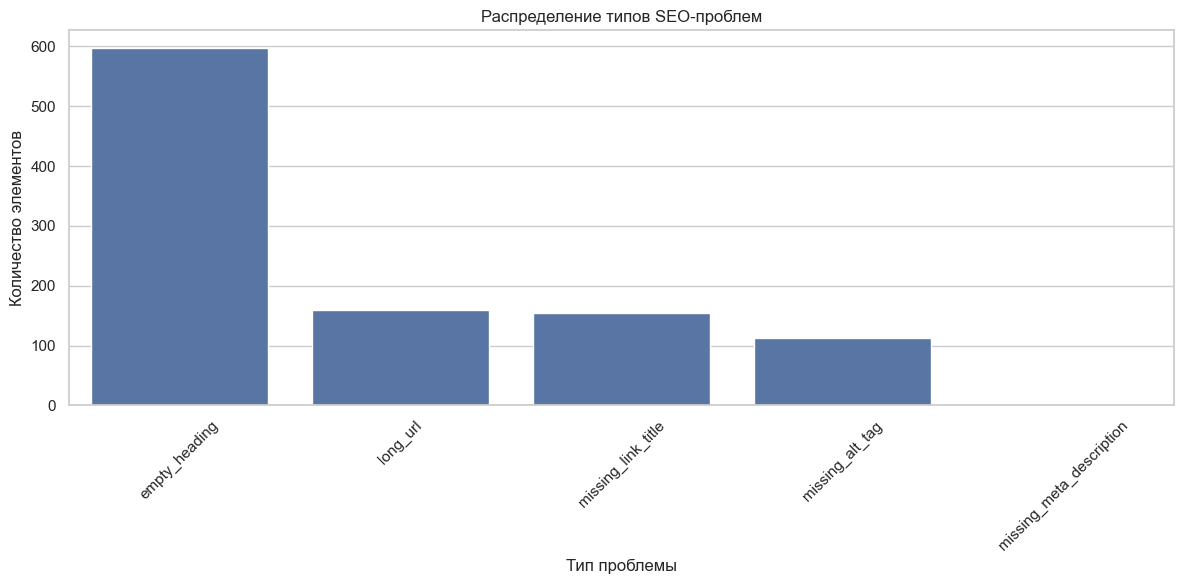

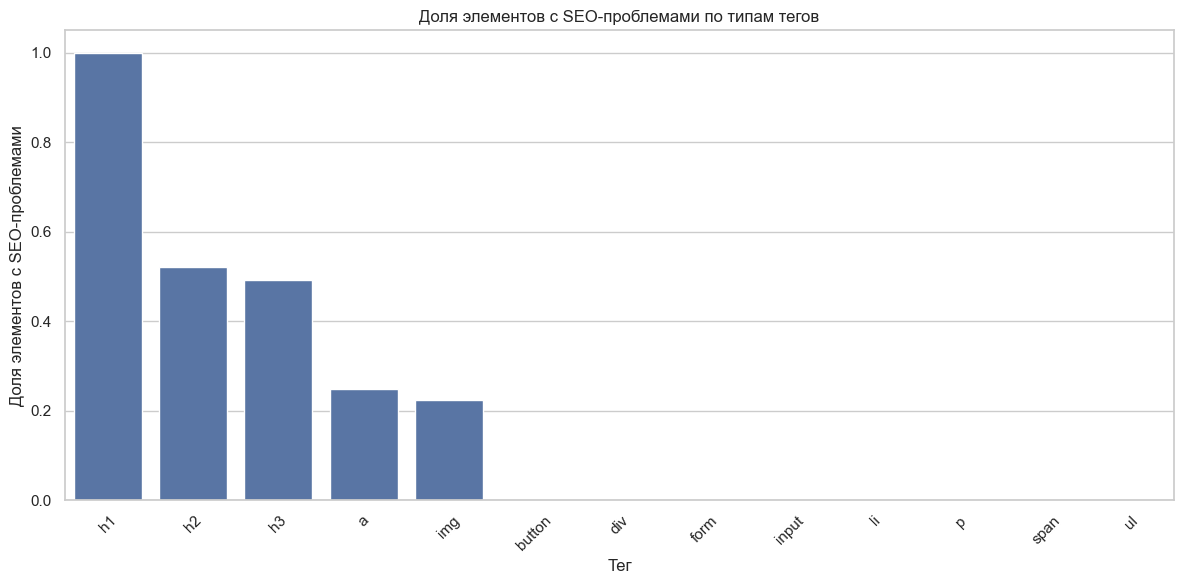

In [116]:
# Визуализируем распределение SEO-проблем
seo_problem_columns = ['missing_alt_tag', 'empty_heading', 'missing_meta_description',
                      'missing_link_title', 'long_url']

try:
    # Количество проблем каждого типа
    seo_problems_count = df_seo[seo_problem_columns].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=seo_problems_count.index, y=seo_problems_count.values)
    plt.title('Распределение типов SEO-проблем')
    plt.xlabel('Тип проблемы')
    plt.ylabel('Количество элементов')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Визуализируем долю элементов с SEO-проблемами по типам тегов
    plt.figure(figsize=(12, 6))
    tag_seo_issues = df_seo.groupby('tag')['has_seo_issues'].mean().sort_values(ascending=False)
    sns.barplot(x=tag_seo_issues.index, y=tag_seo_issues.values)
    plt.title('Доля элементов с SEO-проблемами по типам тегов')
    plt.xlabel('Тег')
    plt.ylabel('Доля элементов с SEO-проблемами')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Ошибка при визуализации SEO-проблем: {e}")


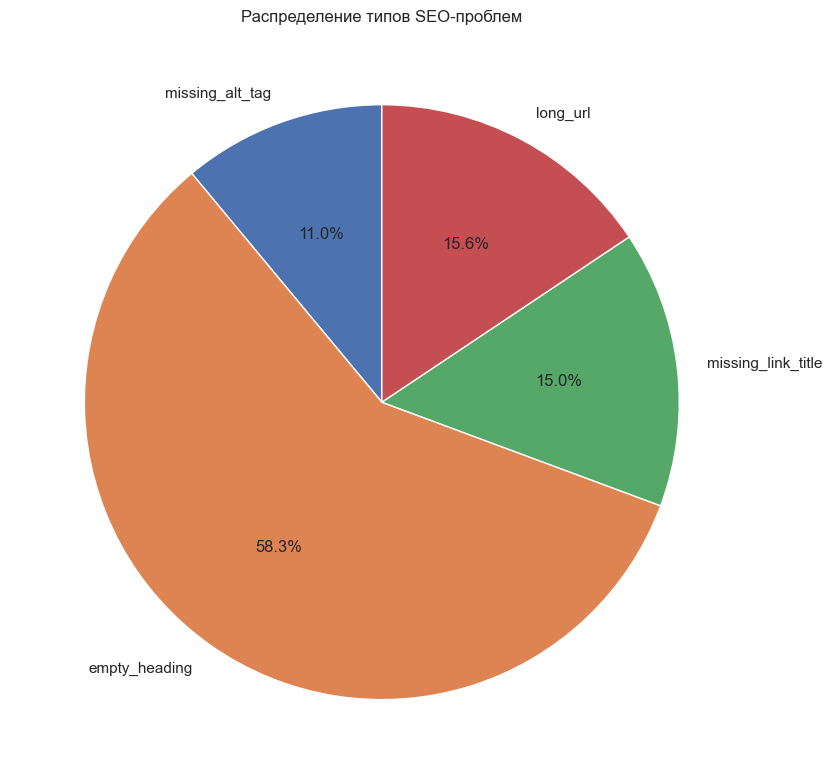

In [117]:
# Круговая диаграмма распределения типов SEO-проблем
try:
    seo_problems = df_seo[seo_problem_columns].sum()
    seo_problems = seo_problems[seo_problems > 0]

    if not seo_problems.empty:
        plt.figure(figsize=(10, 8))
        seo_problems.plot.pie(autopct='%1.1f%%', startangle=90)
        plt.title('Распределение типов SEO-проблем')
        plt.ylabel('')
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно данных для построения диаграммы типов SEO-проблем")
except Exception as e:
    print(f"Ошибка при построении круговой диаграммы: {e}")


## Сравнение "битых" элементов и элементов с SEO-проблемами

В этом разделе мы сравним, как часто "битые" элементы также имеют проблемы с SEO, и наоборот.

Таблица сопряженности между битыми элементами и элементами с SEO-проблемами:
SEO-проблемы   False  True 
Битый элемент              
0               6686    909
1                550    291


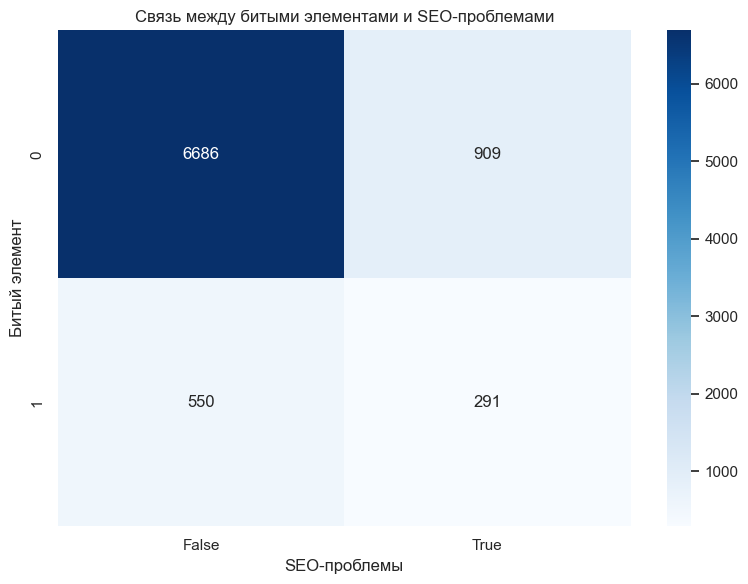

Доля битых элементов с SEO-проблемами: 34.60%
Доля небитых элементов с SEO-проблемами: 11.97%


<Figure size 1000x600 with 0 Axes>

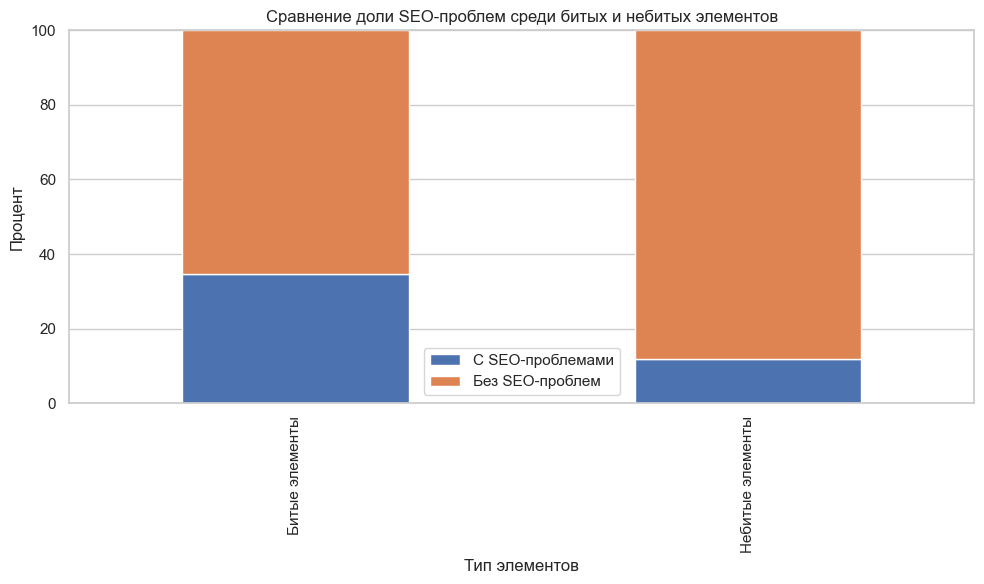


=== ДЕТАЛЬНАЯ ИНФОРМАЦИЯ О ЭЛЕМЕНТАХ С SEO-ПРОБЛЕМАМИ ===

Количество элементов с SEO-проблемами по типам тегов:
- h1: 401 элементов
- a: 276 элементов
- h2: 212 элементов
- h3: 198 элементов
- img: 113 элементов

Детализация по типам SEO-проблем:

Отсутствие атрибута alt у изображений (113 элементов):
- img: 113 элементов

Примеры элементов с проблемой 'Отсутствие атрибута alt у изображений':
  1. Тег: img, Атрибутов: 3, Отсутствует src
  2. Тег: img, Атрибутов: 9, Отсутствует src
  3. Тег: img, Атрибутов: 6, Отсутствует src
  4. Тег: img, Атрибутов: 8, Отсутствует src
  5. Тег: img, Атрибутов: 2, Отсутствует src
... и еще 108 элементов

Пустые заголовки (597 элементов):
- h2: 212 элементов
- h3: 198 элементов
- h1: 187 элементов

Примеры элементов с проблемой 'Пустые заголовки':
  1. Тег: h1, Имеет текст: Нет
  2. Тег: h3, Имеет текст: Нет
  3. Тег: h2, Имеет текст: Нет
  4. Тег: h2, Имеет текст: Нет
  5. Тег: h2, Имеет текст: Нет
... и еще 592 элементов

Дублирование заголовков h1 

In [118]:
# Создаем таблицу сопряженности между битыми элементами и элементами с SEO-проблемами
try:
    contingency_table = pd.crosstab(df_seo['is_broken'], df_seo['has_seo_issues'],
                                    rownames=['Битый элемент'],
                                    colnames=['SEO-проблемы'])

    print("Таблица сопряженности между битыми элементами и элементами с SEO-проблемами:")
    print(contingency_table)

    # Визуализируем таблицу сопряженности
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
    plt.title('Связь между битыми элементами и SEO-проблемами')
    plt.tight_layout()
    plt.show()

    # Вычисляем долю элементов с SEO-проблемами среди битых и небитых элементов
    broken_with_seo_issues = contingency_table.loc[1, True] / contingency_table.loc[1].sum() * 100
    non_broken_with_seo_issues = contingency_table.loc[0, True] / contingency_table.loc[0].sum() * 100

    print(f"Доля битых элементов с SEO-проблемами: {broken_with_seo_issues:.2f}%")
    print(f"Доля небитых элементов с SEO-проблемами: {non_broken_with_seo_issues:.2f}%")

    # Создаем сравнительную диаграмму
    plt.figure(figsize=(10, 6))
    comparison_data = pd.DataFrame({
        'С SEO-проблемами': [broken_with_seo_issues, non_broken_with_seo_issues],
        'Без SEO-проблем': [100 - broken_with_seo_issues, 100 - non_broken_with_seo_issues]
    }, index=['Битые элементы', 'Небитые элементы'])

    comparison_data.plot(kind='bar', stacked=True)
    plt.title('Сравнение доли SEO-проблем среди битых и небитых элементов')
    plt.xlabel('Тип элементов')
    plt.ylabel('Процент')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Выводим детальную информацию о конкретных элементах с SEO-проблемами
    print("\n=== ДЕТАЛЬНАЯ ИНФОРМАЦИЯ О ЭЛЕМЕНТАХ С SEO-ПРОБЛЕМАМИ ===")

    # Находим элементы с SEO-проблемами
    seo_issue_elements = df_seo[df_seo['has_seo_issues'] == True]

    # Выводим информацию о количестве проблемных элементов по типам тегов
    print("\nКоличество элементов с SEO-проблемами по типам тегов:")
    seo_issues_by_tag = seo_issue_elements.groupby('tag').size().sort_values(ascending=False)
    for tag, count in seo_issues_by_tag.items():
        print(f"- {tag}: {count} элементов")

    # Выводим подробную информацию о каждом типе SEO-проблемы
    seo_problem_types = {
        'missing_alt_tag': 'Отсутствие атрибута alt у изображений',
        'empty_heading': 'Пустые заголовки',
        'missing_meta_description': 'Отсутствие мета-описания',
        'incorrect_heading_hierarchy': 'Неправильная иерархия заголовков',
        'duplicate_h1': 'Дублирование заголовков h1',
        'missing_link_title': 'Отсутствие атрибута title у ссылок',
        'long_url': 'Слишком длинные URL в href',
        'invalid_internal_link': 'Невалидные внутренние ссылки'
    }

    print("\nДетализация по типам SEO-проблем:")
    for problem_col, problem_desc in seo_problem_types.items():
        elements_with_problem = df_seo[df_seo[problem_col] == 1]
        if len(elements_with_problem) > 0:
            print(f"\n{problem_desc} ({len(elements_with_problem)} элементов):")

            # Группируем по тегам для этой конкретной проблемы
            problem_by_tag = elements_with_problem.groupby('tag').size().sort_values(ascending=False)

            # Выводим распределение по тегам
            for tag, count in problem_by_tag.items():
                print(f"- {tag}: {count} элементов")

            # Выводим примеры элементов (не более 5 для каждого типа проблемы)
            print(f"\nПримеры элементов с проблемой '{problem_desc}':")
            for i, (_, element) in enumerate(elements_with_problem.iterrows()):
                if i >= 5:  # Ограничиваем количество примеров
                    print(f"... и еще {len(elements_with_problem) - 5} элементов")
                    break

                # Собираем информацию о проблемном элементе
                element_info = f"Тег: {element['tag']}"

                # Добавляем дополнительную информацию в зависимости от тега
                if element['tag'] == 'img':
                    element_info += f", Атрибутов: {element['attr_count']}"
                    if element['missing_required_attr'] == 1:
                        element_info += ", Отсутствует src"
                elif element['tag'] in ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']:
                    element_info += f", Имеет текст: {'Да' if element['has_text'] == 1 else 'Нет'}"
                elif element['tag'] == 'a':
                    element_info += f", Имеет пустые атрибуты: {'Да' if element['has_empty_attr'] == 1 else 'Нет'}"
                    element_info += f", Интерактивный: {'Да' if element['is_interactive'] == 1 else 'Нет'}"

                print(f"  {i+1}. {element_info}")

    # Выводим подробную информацию о элементах, имеющих и SEO-проблемы, и признаки "битости"
    both_issues_elements = df_seo[(df_seo['has_seo_issues'] == True) & (df_seo['is_broken'] == 1)]
    if len(both_issues_elements) > 0:
        print("\n=== ЭЛЕМЕНТЫ С ДВОЙНЫМИ ПРОБЛЕМАМИ (И SEO, И БИТЫЕ) ===")
        print(f"Всего таких элементов: {len(both_issues_elements)}")

        # Группируем по тегам
        both_issues_by_tag = both_issues_elements.groupby('tag').size().sort_values(ascending=False)
        print("\nРаспределение по тегам:")
        for tag, count in both_issues_by_tag.items():
            print(f"- {tag}: {count} элементов")

        # Выводим примеры элементов с двойными проблемами (не более 5)
        print("\nПримеры элементов с двойными проблемами:")
        for i, (_, element) in enumerate(both_issues_elements.iterrows()):
            if i >= 5:  # Ограничиваем количество примеров
                print(f"... и еще {len(both_issues_elements) - 5} элементов")
                break

            # Собираем информацию о проблемах элемента
            seo_issues = []
            for problem_col, problem_desc in seo_problem_types.items():
                if element[problem_col] == 1:
                    seo_issues.append(problem_desc)

            broken_issues = []
            if element['missing_required_attr'] == 1:
                broken_issues.append("Отсутствие обязательного атрибута")
            if element['has_empty_attr'] == 1:
                broken_issues.append("Пустые атрибуты")
            if element['css_conflict'] == 1:
                broken_issues.append("Конфликт CSS")
            if element['has_display_none'] == 1:
                broken_issues.append("Скрытый элемент")
            if element['nested_structure_issue'] == 1:
                broken_issues.append("Проблемы вложенности")

            print(f"  {i+1}. Тег: {element['tag']}")
            print(f"     SEO-проблемы: {', '.join(seo_issues)}")
            print(f"     Проблемы 'битости': {', '.join(broken_issues)}")
            print(f"     Глубина вложенности: {element['depth']}")
except Exception as e:
    print(f"Ошибка при анализе связи между битыми элементами и SEO-проблемами: {e}")


## Интеграция анализа SEO в функцию анализа веб-сайта

Добавим функциональность анализа SEO-проблем в нашу функцию analyze_website, чтобы при анализе реальных сайтов также выявлять элементы с SEO-проблемами.


In [120]:
# Расширенная функция анализа сайта с выявлением SEO-проблем
def analyze_website_with_seo(url, model, max_elements=100, save_to_dataset=False):
    """
    Анализирует веб-сайт, выявляя битые DOM-элементы и элементы с SEO-проблемами

    Args:
        url: URL веб-страницы
        model: обученная модель
        max_elements: максимальное количество элементов для анализа
        save_to_dataset: сохранять ли элементы в датасет

    Returns:
        DataFrame с результатами анализа
    """
    # Получаем и анализируем DOM-элементы с помощью основной функции
    elements_df = analyze_website(url, model, max_elements, save_to_dataset=False)

    if elements_df.empty:
        print("Не удалось получить данные с сайта")
        return pd.DataFrame()

    # Добавляем анализ SEO-проблем
    try:
        # Клонируем DataFrame для SEO-анализа
        seo_df = elements_df.copy()

        # Инициализируем признаки SEO-проблем
        seo_df['missing_alt_tag'] = 0
        seo_df['empty_heading'] = 0
        seo_df['missing_meta_description'] = 0
        seo_df['incorrect_heading_hierarchy'] = 0
        seo_df['duplicate_h1'] = 0
        seo_df['missing_link_title'] = 0
        seo_df['long_url'] = 0
        seo_df['invalid_internal_link'] = 0

        # Анализируем SEO-проблемы по типам тегов

        # Проблема 1: Отсутствие alt у изображений
        img_mask = seo_df['tag'] == 'img'
        for idx, row in seo_df[img_mask].iterrows():
            html = row['element_html']
            # Проверяем наличие атрибута alt
            if 'alt=' not in html or 'alt=""' in html:
                seo_df.loc[idx, 'missing_alt_tag'] = 1

        # Проблема 2: Пустые заголовки
        heading_mask = seo_df['tag'].isin(['h1', 'h2', 'h3', 'h4', 'h5', 'h6'])
        seo_df.loc[heading_mask & (seo_df['has_text'] == 0), 'empty_heading'] = 1

        # Проблема 3: Отсутствие мета-тегов description
        meta_mask = seo_df['tag'] == 'meta'
        for idx, row in seo_df[meta_mask].iterrows():
            html = row['element_html']
            if 'name="description"' not in html.lower():
                seo_df.loc[idx, 'missing_meta_description'] = 1

        # Проблема 4: Неправильная иерархия заголовков
        # Проверяем последовательность заголовков
        headings = seo_df[heading_mask].sort_values('depth')
        if not headings.empty:
            heading_levels = {'h1': 1, 'h2': 2, 'h3': 3, 'h4': 4, 'h5': 5, 'h6': 6}
            prev_level = 0
            for idx, row in headings.iterrows():
                current_level = heading_levels[row['tag']]
                # Если текущий уровень больше предыдущего более чем на 1, это проблема иерархии
                if current_level > prev_level + 1 and prev_level > 0:
                    seo_df.loc[idx, 'incorrect_heading_hierarchy'] = 1
                prev_level = current_level

        # Проблема 5: Дублирование h1
        h1_count = seo_df[seo_df['tag'] == 'h1'].shape[0]
        if h1_count > 1:
            seo_df.loc[seo_df['tag'] == 'h1', 'duplicate_h1'] = 1

        # Проблема 6: Отсутствие title у ссылок
        link_mask = seo_df['tag'] == 'a'
        for idx, row in seo_df[link_mask].iterrows():
            html = row['element_html']
            if 'title=' not in html:
                seo_df.loc[idx, 'missing_link_title'] = 1

        # Проблема 7: Слишком длинные URL
        for idx, row in seo_df[link_mask].iterrows():
            html = row['element_html']
            # Ищем атрибут href
            href_start = html.find('href="')
            if href_start >= 0:
                href_start += 6  # длина 'href="'
                href_end = html.find('"', href_start)
                if href_end >= 0:
                    href = html[href_start:href_end]
                    if len(href) > 100:  # Считаем URL длинным, если он больше 100 символов
                        seo_df.loc[idx, 'long_url'] = 1

        # Проблема 8: Невалидные внутренние ссылки
        for idx, row in seo_df[link_mask].iterrows():
            html = row['element_html']
            href_start = html.find('href="')
            if href_start >= 0:
                href_start += 6
                href_end = html.find('"', href_start)
                if href_end >= 0:
                    href = html[href_start:href_end]
                    # Проверяем невалидные внутренние ссылки (упрощенно)
                    if href.startswith('#') and len(href) == 1:
                        seo_df.loc[idx, 'invalid_internal_link'] = 1
                    elif href == '' or href == 'javascript:void(0)':
                        seo_df.loc[idx, 'invalid_internal_link'] = 1

        # Создаем общий признак для SEO-проблем
        seo_problems = ['missing_alt_tag', 'empty_heading', 'missing_meta_description',
                        'incorrect_heading_hierarchy', 'duplicate_h1', 'missing_link_title',
                        'long_url', 'invalid_internal_link']

        seo_df['has_seo_issues'] = seo_df[seo_problems].sum(axis=1) > 0

        # Выводим статистику SEO-проблем
        print("\n=== РЕЗУЛЬТАТЫ АНАЛИЗА SEO-ПРОБЛЕМ ===")
        print(f"Всего проанализировано элементов: {len(seo_df)}")
        print(f"Элементов с SEO-проблемами: {seo_df['has_seo_issues'].sum()} ({seo_df['has_seo_issues'].mean()*100:.2f}%)")

        # Выводим распределение SEO-проблем по типам
        seo_problems_count = seo_df[seo_problems].sum().sort_values(ascending=False)
        print("\nРаспределение SEO-проблем по типам:")
        for problem, count in seo_problems_count.items():
            if count > 0:
                problem_desc = {
                    'missing_alt_tag': 'Отсутствие атрибута alt у изображений',
                    'empty_heading': 'Пустые заголовки',
                    'missing_meta_description': 'Отсутствие мета-описания',
                    'incorrect_heading_hierarchy': 'Неправильная иерархия заголовков',
                    'duplicate_h1': 'Дублирование заголовков h1',
                    'missing_link_title': 'Отсутствие атрибута title у ссылок',
                    'long_url': 'Слишком длинные URL в href',
                    'invalid_internal_link': 'Невалидные внутренние ссылки'
                }
                print(f"- {problem_desc.get(problem, problem)}: {count} элементов")

        # Выводим детальную информацию о элементах с SEO-проблемами
        print("\n=== ДЕТАЛЬНАЯ ИНФОРМАЦИЯ О ЭЛЕМЕНТАХ С SEO-ПРОБЛЕМАМИ ===")

        # Находим элементы с SEO-проблемами
        seo_issue_elements = seo_df[seo_df['has_seo_issues'] == True].sort_values(['tag', 'probability_broken'], ascending=[True, False])

        # Группируем по тегам
        seo_issues_by_tag = seo_issue_elements.groupby('tag').size()
        print("\nРаспределение элементов с SEO-проблемами по тегам:")
        for tag, count in seo_issues_by_tag.items():
            print(f"- {tag}: {count} элементов")

        # Выводим примеры элементов с SEO-проблемами для каждого тега
        for tag, group in seo_issue_elements.groupby('tag'):
            print(f"\nПримеры элементов с тегом '{tag}' и SEO-проблемами:")

            # Выводим до 3 примеров для каждого тега
            for i, (_, element) in enumerate(group.iterrows()):
                if i >= 3:
                    print(f"... и еще {len(group) - 3} элементов с тегом '{tag}'")
                    break

                # Определяем SEO-проблемы элемента
                element_seo_issues = []
                for problem in seo_problems:
                    if element[problem] == 1:
                        problem_desc = {
                            'missing_alt_tag': 'Отсутствие атрибута alt',
                            'empty_heading': 'Пустой заголовок',
                            'missing_meta_description': 'Отсутствие meta description',
                            'incorrect_heading_hierarchy': 'Неправильная иерархия',
                            'duplicate_h1': 'Дублирование h1',
                            'missing_link_title': 'Отсутствие title',
                            'long_url': 'Длинный URL',
                            'invalid_internal_link': 'Невалидная ссылка'
                        }
                        element_seo_issues.append(problem_desc.get(problem, problem))

                print(f"  {i+1}. {element['element_tag_with_attrs']}")
                print(f"     SEO-проблемы: {', '.join(element_seo_issues)}")
                print(f"     HTML: {element['element_html']}")
                print(f"     Битый элемент: {'Да' if element['predicted_broken'] == 1 else 'Нет'}")
                print("     " + "-" * 40)

        # Объединяем информацию о SEO-проблемах с основным DataFrame
        for problem in seo_problems + ['has_seo_issues']:
            elements_df[problem] = seo_df[problem]

        # Сохраняем данные в датасет, если требуется
        if save_to_dataset:
            try:
                # Создаем подмножество данных для сохранения (без HTML)
                save_columns = [
                    'tag', 'attr_count', 'has_text', 'depth', 'has_empty_attr',
                    'visibility', 'is_interactive', 'has_display_none',
                    'missing_required_attr', 'css_conflict', 'nested_structure_issue',
                    'predicted_broken', 'has_seo_issues'
                ] + seo_problems

                save_df = elements_df[save_columns].copy()
                save_df.rename(columns={'predicted_broken': 'is_broken'}, inplace=True)

                # Определяем путь для сохранения
                save_path = '../data/collected_dom_elements_with_seo.csv'

                # Сохраняем данные
                save_df.to_csv(save_path, index=False)
                print(f"\nДанные анализа сохранены в {save_path}")

            except Exception as e:
                print(f"Ошибка при сохранении данных: {e}")

        return elements_df

    except Exception as e:
        print(f"Ошибка при анализе SEO-проблем: {e}")
        print("Возвращаем результаты без SEO-анализа")
        return elements_df

# Пример использования расширенной функции анализа
# Раскомментируйте следующую строку для запуска анализа с SEO-проверкой
seo_analysis = analyze_website_with_seo("https://ambientlounge.ru/modulnye-divany/collections/mod3-ottoman-trio-yellow-shine-shenill/", loaded_model, 1000)


Получение DOM-элементов с сайта: https://ambientlounge.ru/modulnye-divany/collections/mod3-ottoman-trio-yellow-shine-shenill/
Найдено 1000 DOM-элементов


Анализ элементов: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1476.53it/s]


Результаты анализа:
Всего проанализировано DOM-элементов: 1000
Выявлено битых элементов: 0 (0.00%)

Примеры выявленных битых элементов:
Битых элементов не обнаружено

=== РЕЗУЛЬТАТЫ АНАЛИЗА SEO-ПРОБЛЕМ ===
Всего проанализировано элементов: 1000
Элементов с SEO-проблемами: 0 (0.00%)

Распределение SEO-проблем по типам:

=== ДЕТАЛЬНАЯ ИНФОРМАЦИЯ О ЭЛЕМЕНТАХ С SEO-ПРОБЛЕМАМИ ===

Распределение элементов с SEO-проблемами по тегам:
